In [53]:
import numpy as np 
import pandas as pd 

import math 
from datetime import date, timedelta, datetime 
import time
import os

from pandas.plotting import register_matplotlib_converters 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import seaborn as sns

from sklearn.preprocessing import  MinMaxScaler 

from sklearn.metrics import mean_absolute_error, mean_squared_error 

import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras import backend

from tensorflow.keras.models import load_model
import joblib

import keras_tuner as kt
from keras_tuner.engine.hyperparameters import HyperParameters


from google.cloud import bigquery
from google.oauth2 import service_account

  
print('Tensorflow Version: ' + tf.__version__)


Tensorflow Version: 2.11.1


# Reference Document

* [https://www.relataly.com/stock-price-prediction-multi-output-regression-using-neural-networks-in-python/5800/](https://www.relataly.com/stock-price-prediction-multi-output-regression-using-neural-networks-in-python/5800/)
* [https://www.relataly.com/univariate-stock-market-forecasting-using-a-recurrent-neural-network/122/](https://www.relataly.com/univariate-stock-market-forecasting-using-a-recurrent-neural-network/122/)
* [https://www.relataly.com/stock-market-prediction-using-multivariate-time-series-in-python/1815/](https://www.relataly.com/stock-market-prediction-using-multivariate-time-series-in-python/1815/)
* [https://www.relataly.com/regression-error-metrics-python/923/](https://www.relataly.com/regression-error-metrics-python/923/)
* [https://keras.io/guides/keras_tuner/getting_started/](https://keras.io/guides/keras_tuner/getting_started/)
* [https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/)
* [http://colah.github.io/posts/2015-08-Understanding-LSTMs/](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

In [54]:
start_date='2015-01-01' 
end_date='2023-05-31'
asset_name='QQQ'   

# univaiate  (single feature)
prediction_col='EMA1'
feature_cols=['EMA1']

# multpvaric (nultiple features)
# prediction_col='Close'
# feature_cols=[prediction_col,'EMA1','EMA2','MACD','SIGNAL']

# Load the Data from  BigQuery To Create TrainData as CSV File 

In [55]:
projectId="pongthorn"
dataset_id='FinAssetForecast'
table_data_id=f"{projectId}.{dataset_id}.fin_data"
print(table_data_id)

client = bigquery.Client(project=projectId )

def load_data_bq(sql:str):
 query_result=client.query(sql)
 df=query_result.to_dataframe()
 return df

data_path=f"train_data/{asset_name}_{start_date.replace('-','')}_{end_date.replace('-','')}.csv"

if  os.path.exists(data_path)==False:
    sqlData=f"""
     select * from  `{table_data_id}` where Symbol='{asset_name}' and (Date>='{start_date}' and Date<='{end_date}')
    """
    print(sqlData)
    df=load_data_bq(sqlData)
    df=df.sort_values(by="Date")
    df=df.drop_duplicates(subset=['Date','Symbol'],keep='last')
    df=df.drop(columns=['ImportDateTime'])
    df.to_csv(data_path,index=False)
    print(df.info())
    print("Load Data from BigQuery and Save it as csv.")
else:
    print(f"Load csv {data_path}")

pongthorn.FinAssetForecast.fin_data
Load csv train_data/QQQ_20150101_20230531.csv


# Init Constant Variable

In [56]:
date_col='Date'

main_obj_metric='mean_absolute_error'
main_loss='mean_absolute_error'


input_sequence_length =30  #60 #120
output_sequence_length =5  # 10 #20
train_ratio=0.8

n_epochs =50  #50 #100/150/200
n_batch_size = 100  # 16/32/64

n_early=11  # 16

seed=88

#Tuning
mx_step=2  # 2,3,5,10
mxMultipleStep=1  # double trail
nExecutions_per_trial=3 #3  #averger re-run on 1 trail 

min_drop=0.0
max_drop=  0.1 #0.1 0.2  0.5
step_drop=0.1

defaultMaxTrail=10

ratio_traial_max= 0.5 #0.5 0.7/0.8/1


# Set Tuned-Model Folder

In [57]:
model_path='train_model'
period_str=f"Y{start_date.split('-')[0]}-{end_date.split('-')[0]}"
tune_folder=f'{prediction_col}_{input_sequence_length}To{output_sequence_length}_{asset_name}_E{n_epochs}S{n_early}B{n_batch_size}'
print(tune_folder)

EMA1_30To5_QQQ_E50S11B100


# Read Train Data

In [98]:
df=pd.read_csv(data_path)
df.drop(columns=['Symbol'],inplace=True)

print(df.tail(input_sequence_length+output_sequence_length+2).reset_index(drop=True)[feature_cols])

df.set_index(date_col,inplace=True)
df=df[feature_cols]
print(df.info())

allCols=list(df.columns)
print(allCols)



        EMA1
0   315.4643
1   315.5308
2   315.0780
3   315.8220
4   316.3216
5   316.7795
6   317.1578
7   317.4400
8   317.2291
9   317.1165
10  316.9044
11  315.6473
12  314.9605
13  315.9404
14  317.1440
15  318.0614
16  318.3012
17  318.1173
18  317.7633
19  318.6954
20  319.6035
21  319.9738
22  320.9131
23  321.8743
24  322.4481
25  323.2375
26  323.9507
27  325.2542
28  327.4389
29  329.0882
30  330.6431
31  331.1371
32  331.2303
33  332.7739
34  335.6150
35  338.2268
36  340.0019
<class 'pandas.core.frame.DataFrame'>
Index: 2117 entries, 2015-01-02 to 2023-05-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EMA1    2117 non-null   float64
dtypes: float64(1)
memory usage: 33.1+ KB
None
['EMA1']


In [59]:
print("Split dataframe to show time-dependent data sequencial sample data point)")
_dfTrain=df.loc['2015-01-01':'2021-12-31',:]
print(_dfTrain.shape)  
print(_dfTrain.head())
print(_dfTrain.tail())

print("=========================================================")

_dfTest=df.loc['2022':,:]
print(_dfTest.shape)  
print(_dfTest.head())
print(_dfTest.tail())

Split dataframe to show time-dependent data sequencial sample data point)
(1763, 1)
                EMA1
Date                
2015-01-02  103.8389
2015-01-05  103.4009
2015-01-06  102.7953
2015-01-07  102.5343
2015-01-08  102.6735
                EMA1
Date                
2021-12-27  393.5140
2021-12-28  394.9860
2021-12-29  396.1795
2021-12-30  396.9378
2021-12-31  397.1036
(354, 1)
                EMA1
Date                
2022-01-03  397.9357
2022-01-04  397.6692
2022-01-05  395.2366
2022-01-06  393.1972
2022-01-07  390.7723
                EMA1
Date                
2023-05-24  331.2303
2023-05-25  332.7739
2023-05-26  335.6150
2023-05-30  338.2268
2023-05-31  340.0019


# Exploring the Data

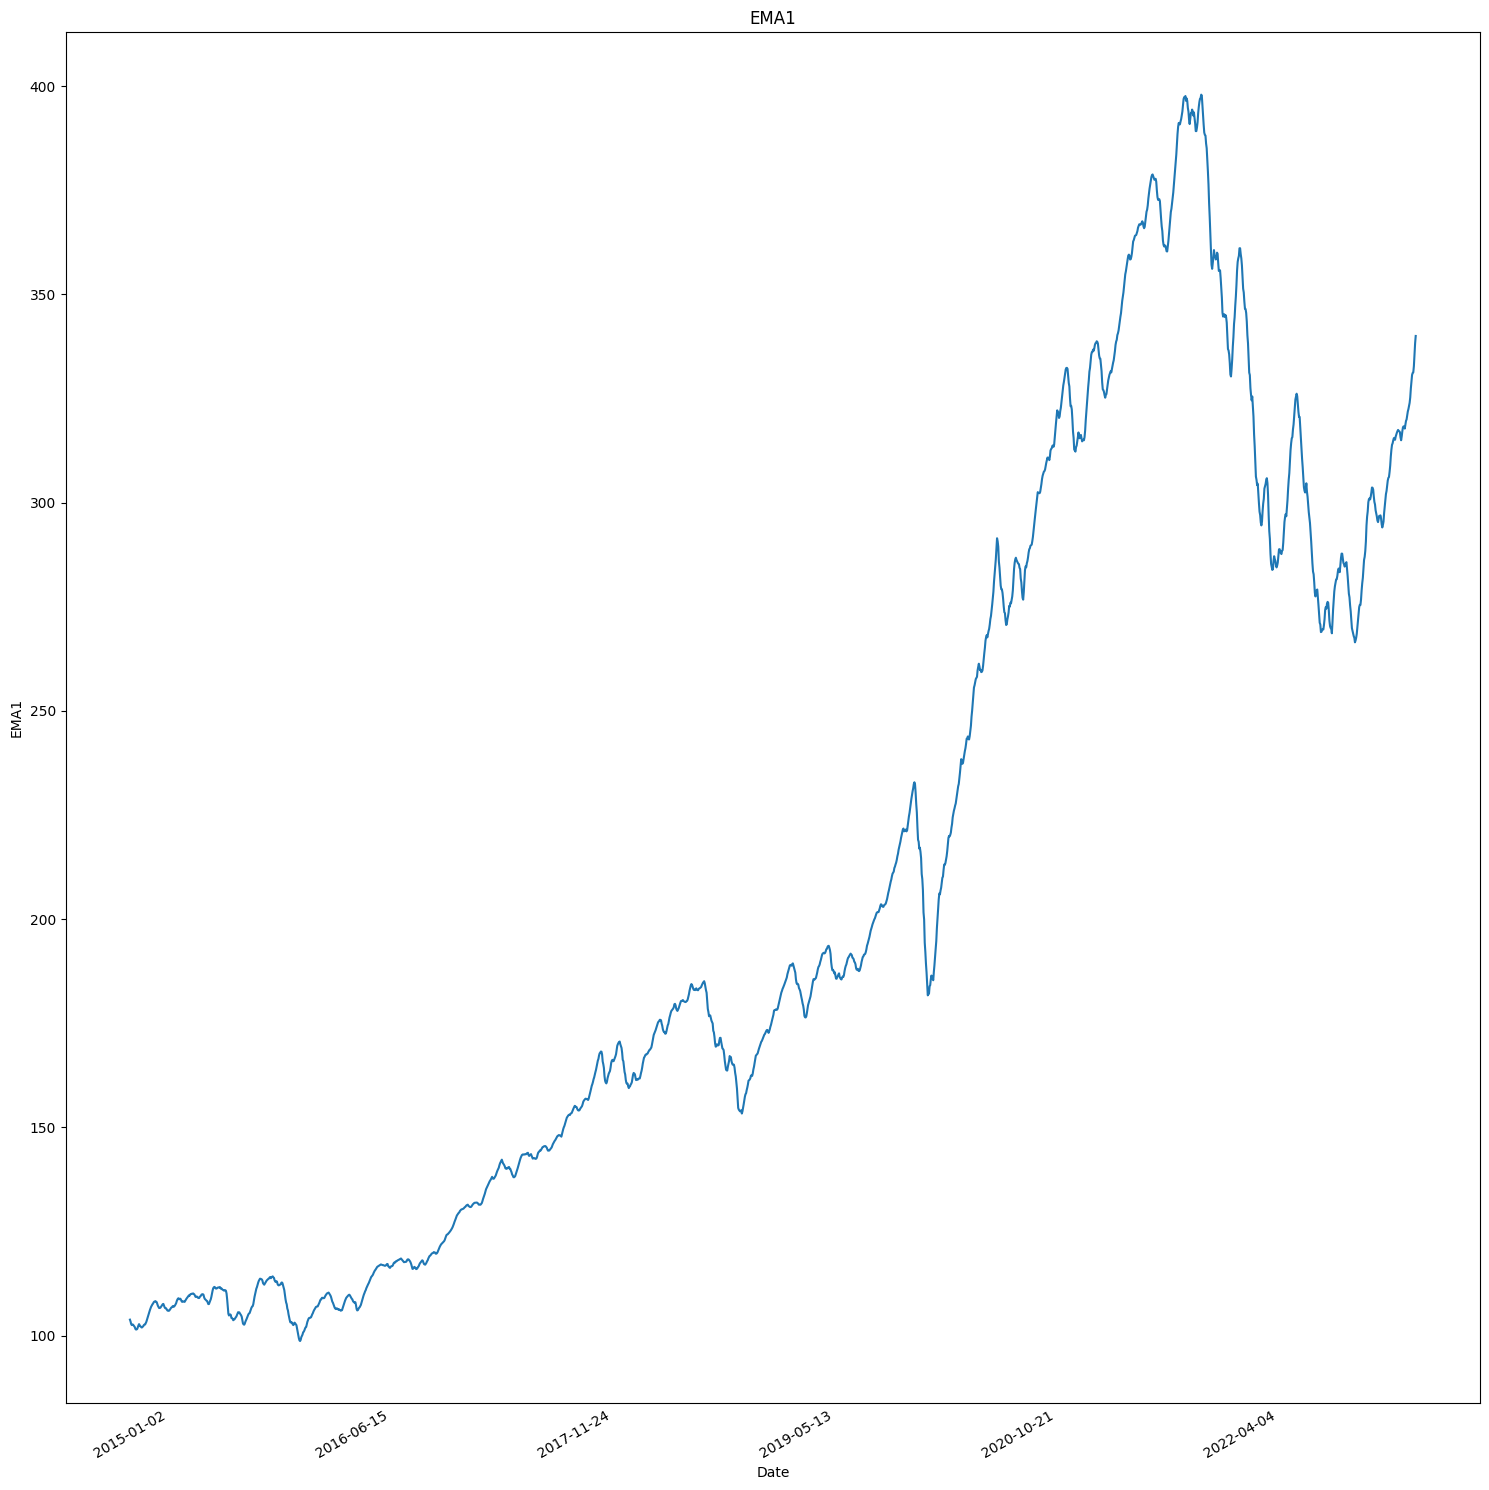

In [60]:
ncols = 1
nrows = len(feature_cols)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(15, 15))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.title.set_text(df.columns[i])
fig.tight_layout()
plt.show()

# Get Data Proper To Train Model

In [61]:
def prepare_data(df):

    print("Convert the data to numpy arrays value")
    np_feature_unscaled = np.array(df)
    np_feature_unscaled = np.reshape(np_feature_unscaled, (df.shape[0], -1))
    print(np_feature_unscaled.shape)
    
    np_pred_unscaled = np.array(df[prediction_col]).reshape(-1, 1)
    print(np_pred_unscaled.shape)
    
    return np_feature_unscaled, np_pred_unscaled

np_feature_unscaled, np_pred_unscaled = prepare_data(df)   


print("Feature Data",np_feature_unscaled.shape)
print(np_feature_unscaled[:3])
print("Prediction Data",np_pred_unscaled.shape)
print(np_pred_unscaled[:3])

Convert the data to numpy arrays value
(2117, 1)
(2117, 1)
Feature Data (2117, 1)
[[103.8389]
 [103.4009]
 [102.7953]]
Prediction Data (2117, 1)
[[103.8389]
 [103.4009]
 [102.7953]]


In [62]:
print(f"{input_sequence_length} = How far back the model looks back during training to forecast).")
print(f"{output_sequence_length} = How far into the future the model forecasts the target value")

#How much ratio to split
index_Prediction = df.columns.get_loc(prediction_col)
print(f"Prediction Index = {index_Prediction}")



30 = How far back the model looks back during training to forecast).
5 = How far into the future the model forecasts the target value
Prediction Index = 0


In [63]:
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_length = math.ceil(np_feature_unscaled.shape[0] * train_ratio)
print(f"{train_ratio} = {train_data_length} Split the training data into train and train data sets")

0.8 = 1694 Split the training data into train and train data sets


In [64]:
print("Scale feature and prediction to a range Max-Min between 0 and 1")
scaler_train = MinMaxScaler()
scaler_pred = MinMaxScaler()


print("Split data and apply only train to scale")

train_data = np_feature_unscaled[0:train_data_length, :]
test_data = np_feature_unscaled[train_data_length - input_sequence_length:, :]

np_PredictVal_unScaled=np_pred_unscaled[0:train_data_length]

print("Train Data to be scaled(feature and prediction)") 
print(train_data.shape,np_PredictVal_unScaled.shape)
print(train_data[:5])
print(np_PredictVal_unScaled[:5])

train_data=scaler_train.fit_transform(train_data)
test_data=scaler_train.transform(test_data)

print(f"For predict test that take the past {input_sequence_length} train value to predict the first test value")
np_scaled=scaler_train.transform(np_feature_unscaled)
np_scaled_prediction = scaler_pred.fit_transform(np_PredictVal_unScaled)

print("==============Scaler Object For Features=================")  
print(f"{scaler_train.n_features_in_} features are scaled in range 0-1 such as {feature_cols}")
print(f"Max:{scaler_train.data_max_} -  Min:{scaler_train.data_min_}")

print("==============Scaler Object For Prediction Target Value=================")  
print(f"{scaler_pred.n_features_in_} pred col is scaled in range 0-1 such as {prediction_col}")
print(f"Max:{scaler_pred.data_max_} -  Min:{scaler_pred.data_min_}")


print("=========================================")       
print("Scaled data completely")
print("Scaled train and test data")
print(train_data.shape,test_data.shape)
print(train_data[:5])
print(test_data[:5])

print("=========================================")  
print("Scale Prediction data (Scaled from Train data)")
print(np_scaled_prediction.shape)
print(np_scaled_prediction[:5])



Scale feature and prediction to a range Max-Min between 0 and 1
Split data and apply only train to scale
Train Data to be scaled(feature and prediction)
(1694, 1) (1694, 1)
[[103.8389]
 [103.4009]
 [102.7953]
 [102.5343]
 [102.6735]]
[[103.8389]
 [103.4009]
 [102.7953]
 [102.5343]
 [102.6735]]
For predict test that take the past 30 train value to predict the first test value
==============Scaler Object For Features=================
1 features are scaled in range 0-1 such as ['EMA1']
Max:[378.776] -  Min:[98.7107]
==============Scaler Object For Prediction Target Value=================
1 pred col is scaled in range 0-1 such as EMA1
Max:[378.776] -  Min:[98.7107]
Scaled data completely
Scaled train and test data
(1694, 1) (453, 1)
[[0.01831073]
 [0.01674681]
 [0.01458446]
 [0.01365253]
 [0.01414956]]
[[0.95741779]
 [0.95869642]
 [0.95984686]
 [0.95867785]
 [0.95543646]]
Scale Prediction data (Scaled from Train data)
(1694, 1)
[[0.01831073]
 [0.01674681]
 [0.01458446]
 [0.01365253]
 [0.01

# Creating the Input data  as 3 dimension array (samples, time steps, features]

In [65]:
print("The LSTM RNN needs data with the format of [sample rows, time steps, features]")
def partition_dataset(input_sequence_length, output_sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(input_sequence_length, data_len - output_sequence_length):
        x.append(data[i-input_sequence_length:i,:])
        y.append(data[i:i + output_sequence_length, index_Prediction]) 
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

The LSTM RNN needs data with the format of [sample rows, time steps, features]


In [66]:
print(f"Here, we create {len(train_data)} samples, input_sequence_length time steps per sample, and features")

print("Generate training data and test data")
x_train, y_train = partition_dataset(input_sequence_length, output_sequence_length, train_data)
x_test, y_test = partition_dataset(input_sequence_length, output_sequence_length, test_data)

print("The shapes: the result is: (rows, training_sequence, features) (prediction value, )")
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

print(f"Use {prediction_col} samples over the past {input_sequence_length} days to predict the future over the next {output_sequence_length} days")
print(x_train[-1:],y_train[-1:])

Here, we create 1694 samples, input_sequence_length time steps per sample, and features
Generate training data and test data
The shapes: the result is: (rows, training_sequence, features) (prediction value, )
(1659, 30, 1) (1659, 5)
(418, 30, 1) (418, 5)
Use EMA1 samples over the past 30 days to predict the future over the next 5 days
[[[0.9514656 ]
  [0.9543785 ]
  [0.95570997]
  [0.95724104]
  [0.95726639]
  [0.95687827]
  [0.95741779]
  [0.95869642]
  [0.95984686]
  [0.95867785]
  [0.95543646]
  [0.95392039]
  [0.95512725]
  [0.95968547]
  [0.96415515]
  [0.96809101]
  [0.96976634]
  [0.97348725]
  [0.97927126]
  [0.98380235]
  [0.98791853]
  [0.9911692 ]
  [0.99458876]
  [0.99773696]
  [0.99944941]
  [1.        ]
  [0.99858105]
  [0.997251  ]
  [0.9954682 ]
  [0.99582097]]] [[0.99627837 0.99374396 0.98639246 0.98066987 0.97820794]]


# Model Training

# Paramterter Network

In [70]:
# Configure the neural network model
# tf.random.set_seed(7)
print("Keras Tuning Parameter Setting")

model = Sequential()
n_output_neurons = output_sequence_length
  
inputshape_Timestamps= x_train.shape[1]
no_feature=x_train.shape[2]
neuron_number =inputshape_Timestamps * no_feature


step_neuron=int(neuron_number)
max_neuron=int(step_neuron*mx_step)
print(f"Train Row : {x_train.shape[0]}")
print(f"{inputshape_Timestamps}(backward step) x {no_feature}(features) = {neuron_number}, it is total no.NN  to predict future {n_output_neurons} with Hidden Node Unit from {step_neuron} to {max_neuron}")
    


neuron_list = [*range(neuron_number, max_neuron+step_neuron, step_neuron)]

drop_list=np.arange (min_drop, max_drop ,step_drop)
drop_list=np.append(drop_list,[max_drop])

allPosComb=len(neuron_list)*len(drop_list)
print(f"{neuron_list} and {drop_list}")
print(f"all combination : {len(neuron_list)} x {len(drop_list)} = {allPosComb}")

nMax_trials=math.ceil(allPosComb*ratio_traial_max)
nMax_trials=nMax_trials*mxMultipleStep

# if nMax_trials<defaultMaxTrail: 
#     nMax_trials=defaultMaxTrail

nMax_trials=nMax_trials*1
print("MAx run :" ,nMax_trials , "each trail run to essemble ",nExecutions_per_trial)

Keras Tuning Parameter Setting
Train Row : 1659
30(backward step) x 1(features) = 30, it is total no.NN  to predict future 5 with Hidden Node Unit from 30 to 60
[30, 60] and [0.  0.1]
all combination : 2 x 2 = 4
MAx run : 2 each trail run to essemble  3


# NetWork Architeture Model Design

In [71]:
def build_model_way(hp):
    
    model = Sequential()

    model.add(LSTM( hp.Int('input_unit',min_value=neuron_number ,max_value=max_neuron,step=step_neuron) \
                   , return_sequences=False, input_shape=(inputshape_Timestamps,no_feature)))
    
    model.add(Dropout(hp.Float('Dropout_rate',min_value=min_drop,max_value=max_drop,step=step_drop))) 
    
    model.add(Dense(n_output_neurons))

    model.compile(optimizer="adam", loss=main_loss, metrics=[main_obj_metric])
    return model

# Start Tuning 

In [72]:
buildtime = datetime.now().strftime('%d%m%y_%H%M')
project_model=f"{buildtime}"
print(project_model)


t_Start=time.time()

print(f"Start tund at {datetime.now()}")

200623_2303
Start tund at 2023-06-20 23:03:47.018287


In [73]:
early_stop = EarlyStopping(monitor='val_loss', patience=n_early, verbose=1)

tuner = kt.BayesianOptimization(
# tuner = kt.Hyperband(
# tuner= kt.RandomSearch(
        build_model_way,
        objective=main_obj_metric,
        max_trials=nMax_trials,
        seed=seed,
        executions_per_trial=nExecutions_per_trial,
        directory=f"tuning/{tune_folder}/",
        project_name= project_model
   
        )
tuner.search(x_train, y_train, batch_size=n_batch_size, epochs=n_epochs,
                        validation_data=(x_test, y_test),
                        shuffle=False,verbose=1,callbacks=[early_stop])



Trial 2 Complete [00h 01m 23s]
mean_absolute_error: 0.02284440832833449

Best mean_absolute_error So Far: 0.01540357650568088
Total elapsed time: 00h 02m 40s
INFO:tensorflow:Oracle triggered exit


In [74]:
print("Space to search")
tuner.search_space_summary()
print(f"Suumary of {nMax_trials}")
tuner.results_summary()

Space to search
Search space summary
Default search space size: 2
input_unit (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 60, 'step': 30, 'sampling': 'linear'}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.1, 'step': 0.1, 'sampling': 'linear'}
Suumary of 2
Results summary
Results in tuning/EMA1_30To5_QQQ_E50S11B100/200623_2303
Showing 10 best trials
Objective(name="mean_absolute_error", direction="min")

Trial 0 summary
Hyperparameters:
input_unit: 30
Dropout_rate: 0.0
Score: 0.01540357650568088

Trial 1 summary
Hyperparameters:
input_unit: 30
Dropout_rate: 0.1
Score: 0.02284440832833449


In [75]:
t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execution : ',round(t_elapsed,2)) 
print(datetime.now())

Total execution :  0.04
2023-06-20 23:06:28.270226


# Get Optimal HyperParamters

In [76]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)
print("build model from  the best tuning")

# model=tuner.get_best_models(num_models=1)[0]

model = tuner.hypermodel.build(best_hps)
print(model.summary())

{'input_unit': 30, 'Dropout_rate': 0.0}
build model from  the best tuning
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 30)                3840      
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 155       
                                                                 
Total params: 3,995
Trainable params: 3,995
Non-trainable params: 0
_________________________________________________________________
None


# Training the TUNED Model 

In [77]:
print(f"Training the Best Model")
t_Start=time.time()
print(datetime.now())


early_stop = EarlyStopping(monitor='val_loss', patience=n_early, verbose=1)
history = model.fit(x_train, y_train, 
                batch_size=n_batch_size, 
                epochs=n_epochs,
                shuffle=False,
                validation_data=(x_test, y_test),
                verbose=2, callbacks=[early_stop]
               )
        
t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execute making report : ',round(t_elapsed,2)) 
print(datetime.now())

Training the Best Model
2023-06-20 23:10:18.471499
Epoch 1/50
17/17 - 4s - loss: 0.2154 - mean_absolute_error: 0.2154 - val_loss: 0.5003 - val_mean_absolute_error: 0.5003 - 4s/epoch - 225ms/step
Epoch 2/50
17/17 - 0s - loss: 0.1192 - mean_absolute_error: 0.1192 - val_loss: 0.2305 - val_mean_absolute_error: 0.2305 - 354ms/epoch - 21ms/step
Epoch 3/50
17/17 - 0s - loss: 0.1131 - mean_absolute_error: 0.1131 - val_loss: 0.1750 - val_mean_absolute_error: 0.1750 - 390ms/epoch - 23ms/step
Epoch 4/50
17/17 - 0s - loss: 0.0496 - mean_absolute_error: 0.0496 - val_loss: 0.0846 - val_mean_absolute_error: 0.0846 - 424ms/epoch - 25ms/step
Epoch 5/50
17/17 - 0s - loss: 0.0413 - mean_absolute_error: 0.0413 - val_loss: 0.0741 - val_mean_absolute_error: 0.0741 - 453ms/epoch - 27ms/step
Epoch 6/50
17/17 - 0s - loss: 0.0443 - mean_absolute_error: 0.0443 - val_loss: 0.0671 - val_mean_absolute_error: 0.0671 - 488ms/epoch - 29ms/step
Epoch 7/50
17/17 - 0s - loss: 0.0844 - mean_absolute_error: 0.0844 - val_lo

In [78]:
val_per_epoch = history.history[main_obj_metric]
best_epoch = len(val_per_epoch) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 50


In [79]:
print("List Metrics")
for key in history.history.keys():
    print(key)
print("=====================================================")    
# Evaluate the model on the test data using `evaluate`
#https://www.tensorflow.org/guide/keras/train_and_evaluate
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=n_batch_size)
print("test loss, test acc:", results)

List Metrics
loss
mean_absolute_error
val_loss
val_mean_absolute_error
Evaluate on test data
5/5 [==============================] - 0s 14ms/step - loss: 0.0311 - mean_absolute_error: 0.0311
test loss, test acc: [0.031084824353456497, 0.031084824353456497]


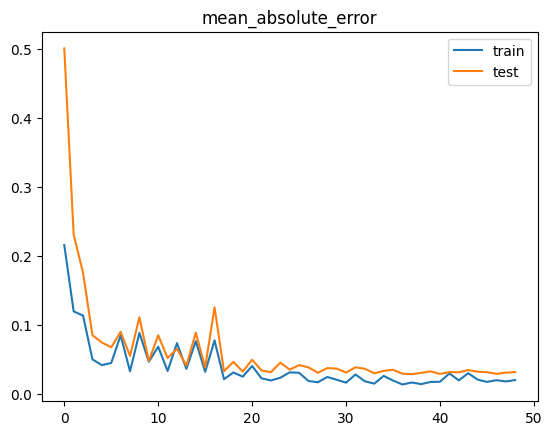

In [80]:
plt.title(main_obj_metric)
plt.plot(history.history[main_obj_metric], label='train')
plt.plot(history.history[f'val_{main_obj_metric}'], label='test')
plt.legend()
plt.show()

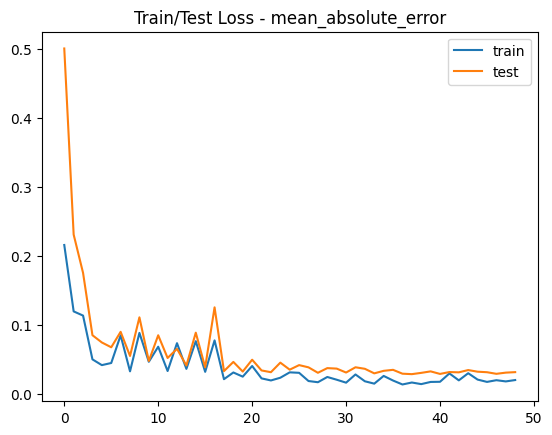

In [81]:
plt.title(f"Train/Test Loss - {main_loss}")
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Step #5 Evaluate Model Performance

In [82]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)
# print(y_pred_scaled.shape)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test).reshape(-1, output_sequence_length)
print(y_pred.shape)
print(y_test_unscaled.shape)

14/14 [==============================] - 3s 11ms/step
(418, 5)
(418, 5)


In [83]:
dfTestActual=pd.DataFrame(data=y_test_unscaled, \
                          columns=[ f"Step{x}-{prediction_col}"  for x in range(1,output_sequence_length+1,1)])
dfTestPred=pd.DataFrame(data=y_pred, \
                          columns=[ f"Step{x}-Pred-{prediction_col}"  for x in range(1,output_sequence_length+1,1)]) 
dfActualPred=pd.concat([dfTestActual,dfTestPred],axis=1)
ActualPredcols=sorted(dfActualPred.columns.tolist())
dfActualPred=dfActualPred[ActualPredcols]
dfActualPred.head(3)

,Step1-EMA1,Step1-Pred-EMA1,Step2-EMA1,Step2-Pred-EMA1,Step3-EMA1,Step3-Pred-EMA1,Step4-EMA1,Step4-Pred-EMA1,Step5-EMA1,Step5-Pred-EMA1
0,372.8380,364.793762,372.3856,383.095581,370.1100,382.377838,368.1409,367.883118,366.2899,381.849060
1,372.3856,364.377167,370.1100,382.555664,368.1409,381.935547,366.2899,367.575989,365.1790,381.442627
2,370.1100,363.945770,368.1409,382.014221,366.2899,381.485535,365.1790,367.231537,362.8955,381.028870


In [84]:
# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')
print("===========================================================================")

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')


# Root Mean  Squre Error
# RMSE = math.sqrt( mean_squared_error(y_test_unscaled, y_pred))
# print(f'Root MEAN Square Error(RMSE): {np.round(RMSE, 2)}')


Mean Absolute Error (MAE): 8.71
Mean Absolute Percentage Error (MAPE): 2.71 %


# Plot Multiple Forcast (Most Complex Step)

In [85]:
def prepare_df(i, x, y, y_pred_unscaled):
    # Undo the scaling on x, reshape the testset into a one-dimensional array, so that it fits to the pred scaler
    x_test_unscaled_df = pd.DataFrame(scaler_pred.inverse_transform((x[i]))[:,index_Prediction])\
    .rename(columns={0:'x_test'})
    
    y_test_unscaled_df = []
    # Undo the scaling on y
    if type(y) == np.ndarray:
        y_test_unscaled_df = pd.DataFrame(scaler_pred.inverse_transform(y)[i]).rename(columns={0:'y_test'})

    # Create a dataframe for the y_pred at position i, y_pred is already unscaled
    y_pred_df = pd.DataFrame(y_pred_unscaled[i]).rename(columns={0:'y_pred'})
    return x_test_unscaled_df, y_pred_df, y_test_unscaled_df


def plot_multi_test_forecast(x_test_unscaled_df, y_test_unscaled_df, y_pred_df, title): 
    # Package y_pred_unscaled and y_test_unscaled into a dataframe with columns pred and true   
    if type(y_test_unscaled_df) == pd.core.frame.DataFrame:
        df_merge = y_pred_df.join(y_test_unscaled_df, how='left')
    else:
        df_merge = y_pred_df.copy()
    
    # Merge the dataframes 
    df_merge_ = pd.concat([x_test_unscaled_df, df_merge]).reset_index(drop=True)
    
    # Plot the linecharts
    fig, ax = plt.subplots(figsize=(20, 8))
    plt.title(title, fontsize=12)
    ax.set(ylabel = f"{asset_name}-{prediction_col}")
    sns.lineplot(data = df_merge_, linewidth=2.0, ax=ax)



# Step #6 Create a new Forecast

In [86]:
x_test_latest_batch = np_scaled[-(input_sequence_length+1):-1,:].reshape(1,input_sequence_length,len(feature_cols))
print(f"{x_test_latest_batch.shape} is the latest input batch from the test dataset, which is contains the price values for the last {input_sequence_length} trading days")

x_test_latest_batch

(1, 30, 1) is the latest input batch from the test dataset, which is contains the price values for the last 30 trading days


array([[[0.77998631],
        [0.78099393],
        [0.78024089],
        [0.77983884],
        [0.77908152],
        [0.77459293],
        [0.77214064],
        [0.77563947],
        [0.77993704],
        [0.7832127 ],
        [0.78406893],
        [0.7834123 ],
        [0.78214831],
        [0.78547646],
        [0.78871892],
        [0.79004111],
        [0.79339497],
        [0.79682703],
        [0.79887583],
        [0.80169446],
        [0.80424101],
        [0.80889528],
        [0.81669596],
        [0.82258495],
        [0.82813687],
        [0.82990074],
        [0.83023352],
        [0.83574509],
        [0.84588951],
        [0.85521519]]])

In [87]:
y_pred_scaled = model.predict(x_test_latest_batch)
y_pred_unscaled = scaler_pred.inverse_transform(y_pred_scaled)
print(f"Predict on the inverse transformed batch {y_pred_unscaled.shape}")
print(y_pred_unscaled)

1/1 [==============================] - 0s 37ms/step
Predict on the inverse transformed batch (1, 5)
[[326.15808 336.78662 338.47675 327.8994  337.90573]]


In [88]:
print("Prepare the data and plot the input data and the predictions")
x_test_unscaled_df, y_test_unscaled_df, _ = prepare_df(0, x_test_latest_batch, '', y_pred_unscaled)
print(f"X-Test= {x_test_unscaled_df.shape}")
print(f"Y-Test= {y_test_unscaled_df.shape}")

# print(x_test_unscaled_df.tail(len(y_test_unscaled_df)))
# print(y_test_unscaled_df.tail(len(y_test_unscaled_df)))

Prepare the data and plot the input data and the predictions
X-Test= (30, 1)
Y-Test= (5, 1)


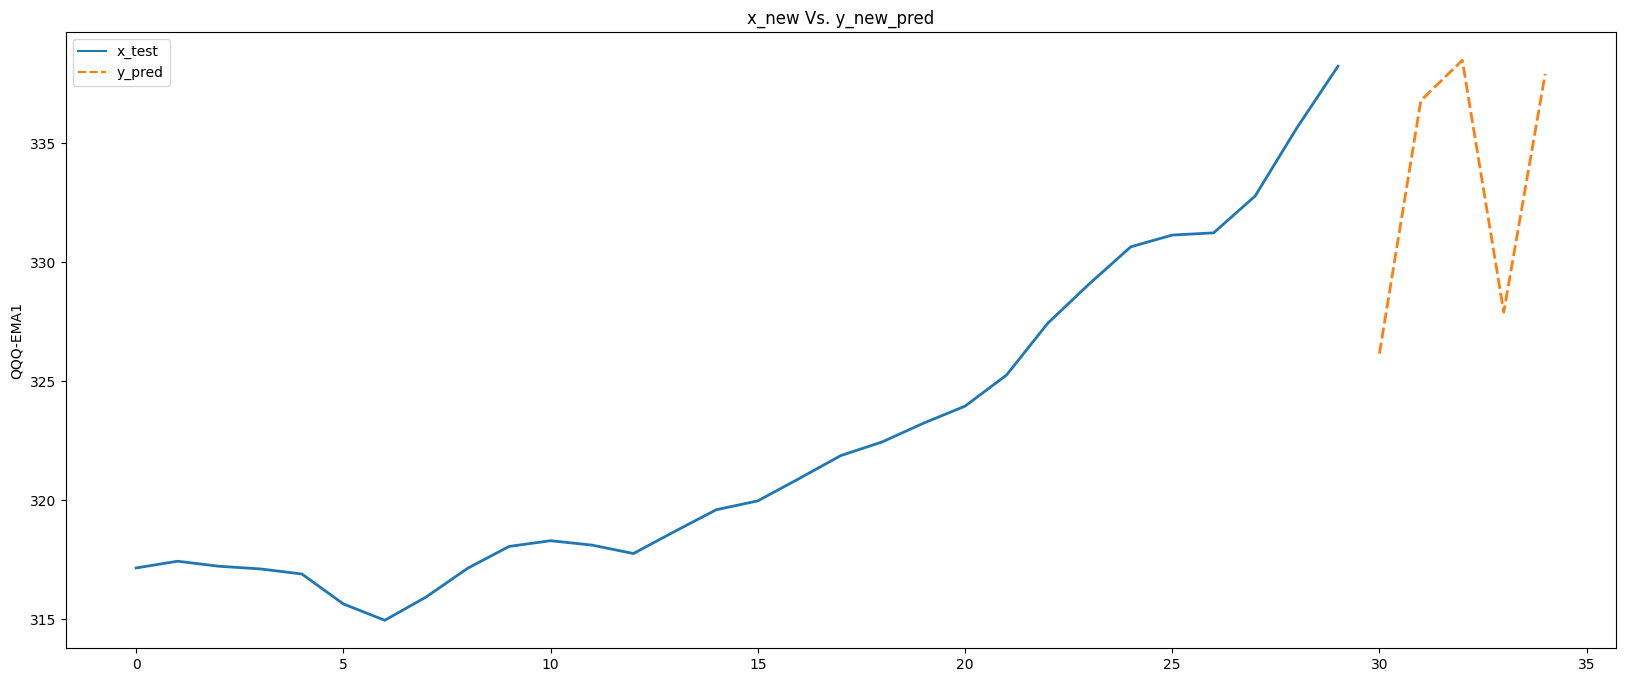

In [89]:
plot_multi_test_forecast(x_test_unscaled_df, '',y_test_unscaled_df, "x_new Vs. y_new_pred")

#### 

# Create Final Model

In [90]:
dfAll=df.sort_values(by=[date_col]).copy()
npAll_unscaled, npPredictCol_unscaled = prepare_data(dfAll) 
print(npAll_unscaled.shape,npPredictCol_unscaled.shape)

Convert the data to numpy arrays value
(2117, 1)
(2117, 1)
(2117, 1) (2117, 1)


In [91]:
scalerFinalTrain = MinMaxScaler()
scalerFinalPred = MinMaxScaler()
npAll_scaled = scalerFinalTrain.fit_transform(npAll_unscaled)
npAllPredictCol_scaled = scalerFinalPred.fit_transform(npPredictCol_unscaled)
print(npAll_scaled.shape,npAllPredictCol_scaled.shape)
print(npAll_scaled[:2])
print(npAllPredictCol_scaled[:2])

(2117, 1) (2117, 1)
[[0.01713827]
 [0.01567449]]
[[0.01713827]
 [0.01567449]]


In [92]:
x_all, y_all = partition_dataset(input_sequence_length, output_sequence_length,npAll_scaled)
print(f"We will tranin {x_all.shape},{y_all.shape} with batch={n_batch_size} and best epoch={best_epoch}")

We will tranin (2082, 30, 1),(2082, 5) with batch=100 and best epoch=50


In [93]:
print(f"Training All")
t_Start=time.time()
print(datetime.now())

history_final=model.fit(x=x_all, y=y_all, batch_size=n_batch_size, epochs=best_epoch,shuffle=False)
        
t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execute making report : ',round(t_elapsed,2)) 
print(datetime.now())

Training All
2023-06-20 23:11:56.954834
Epoch 1/50
21/21 [==============================] - 1s 24ms/step - loss: 0.0152 - mean_absolute_error: 0.0152
Epoch 2/50
21/21 [==============================] - 1s 28ms/step - loss: 0.0192 - mean_absolute_error: 0.0192
Epoch 3/50
21/21 [==============================] - 1s 29ms/step - loss: 0.0200 - mean_absolute_error: 0.0200
Epoch 4/50
21/21 [==============================] - 1s 27ms/step - loss: 0.0220 - mean_absolute_error: 0.0220
Epoch 5/50
21/21 [==============================] - 1s 29ms/step - loss: 0.0168 - mean_absolute_error: 0.0168
Epoch 6/50
21/21 [==============================] - 1s 36ms/step - loss: 0.0173 - mean_absolute_error: 0.0173
Epoch 7/50
21/21 [==============================] - 1s 37ms/step - loss: 0.0152 - mean_absolute_error: 0.0152
Epoch 8/50
21/21 [==============================] - 1s 32ms/step - loss: 0.0178 - mean_absolute_error: 0.0178
Epoch 9/50
21/21 [==============================] - 1s 35ms/step - loss: 0.0152 

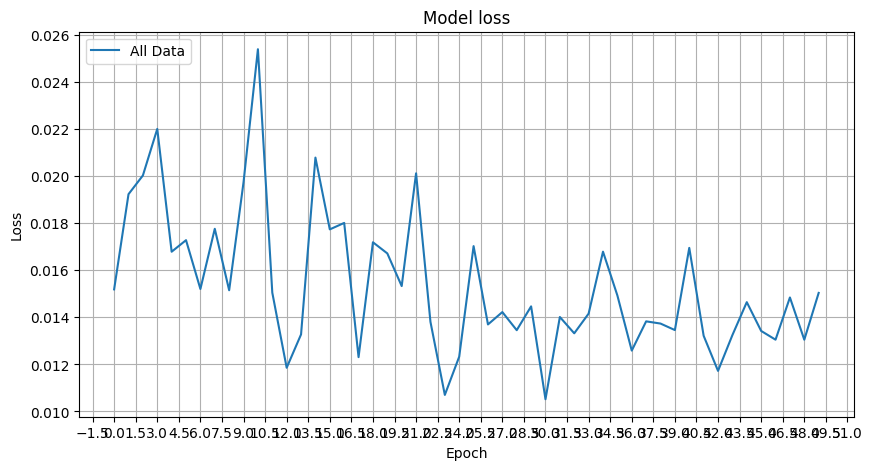

In [94]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
plt.plot(history_final.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(n_epochs))
plt.legend(["All Data"], loc="upper left")
plt.grid()
plt.show()

In [95]:
print("Save model and scaler")
modelName=f"{tune_folder}-{period_str}"
#modelName='test2022-20for10'
file_model=f'{model_path}/{modelName}_ma.h5'
file_scaler=f'{model_path}/scaler_{modelName}.gz'
file_scaler_pred=f'{model_path}/scaler_pred_{modelName}.gz'

model.save(file_model)

joblib.dump(scalerFinalTrain,file_scaler)
joblib.dump(scalerFinalPred ,file_scaler_pred)

Save model and scaler


['train_model/scaler_pred_EMA1_30To5_QQQ_E50S11B100-Y2015-2023.gz']